# Building an AI Agent

## 1. Setup

In [1]:
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Annotated, Literal, TypedDict
import uuid

# LangChain / OpenAI
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, BaseMessage

# LangGraph Core
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command, interrupt

# Load environment variables
load_dotenv()

# Model name
MODEL_NAME = "gpt-5-mini"

## 2. Defining Tools

In [2]:
# Initialize the tool
tavily_search = TavilySearch(
    max_results=2,                 # Number of search results to retrieve
    search_depth="basic",          # "basic" (fast) or "advanced" (higher quality)
    include_answer=False,          # Do not include Tavily’s short generated answer
    include_raw_content=False,     # Include raw HTML content (watch token usage)
    include_images=False,          # Include image URLs
    # include_domains=["go.jp"],   # Search only specific domains
    # exclude_domains=["wikipedia.org"] # Exclude specific domains
)

# Format only Tavily’s search results into something readable for an LLM
def format_tavily_results(tavily_response: dict) -> str:
    results = tavily_response.get("results", [])
    if not results:
        return "(No search results)"

    lines = []
    for i, r in enumerate(results, 1):
        title = r.get("title", "")
        content = r.get("content", "")
        url = r.get("url", "")
        lines.append(f"[{i}] {title}\n{content}\nsource: {url}")
    return "\n\n".join(lines)

# A wrapper Tool that formats Tavily’s raw response (dict/JSON) and returns it
@tool
def tavily_search_formatted(query: str) -> str:
    """Web search (Tavily). Returns formatted top results."""
    tavily_response = tavily_search.invoke({"query": query})
    return format_tavily_results(tavily_response)

tools = [tavily_search_formatted]

## 3. Defining State and Model

In [3]:
class State(TypedDict):
    # Use add_messages to append messages to history
    research_messages: Annotated[list[BaseMessage], add_messages]
    analysis_messages: Annotated[list[BaseMessage], add_messages]
    # Counters and similar values can be overwritten
    loop_count: int

# Initialize the model
model = ChatOpenAI(model=MODEL_NAME)
model_with_tools = model.bind_tools(tools)


## 4. Defining Nodes

In [4]:
# Debug helper
DEBUG_MODE = True  # Set to True to print detailed logs

def print_debug(title, content):
    if DEBUG_MODE:
        print(f"\n🐛 [DEBUG] {title}:\n{content}\n" + "-"*40)

In [5]:
MAX_TOOL_LOOPS = 3

research_prompt_text = """
You are responsible for business research. For the user’s theme, investigate market size, key players, technical challenges, and more using web search. Use the best tools as needed.
When you answer after calling a tool (only when the tool results include URLs), do the following:
- Add referenced source numbers at the end of the answer (e.g., [1][2])
- Finally, list source numbers and URLs as bullet points
"""

research_prompt = ChatPromptTemplate.from_messages([
    ("system", research_prompt_text),
    MessagesPlaceholder(variable_name="research_messages")
])
research_chain = research_prompt | model_with_tools

def research_agent(state: State) -> Command[Literal["tools", "summary_agent"]]:
    print("🔍 Research Agent: thinking...")

    response = research_chain.invoke({"research_messages": state["research_messages"]})

    update = {"research_messages": [response]}
    current_count = state.get("loop_count", 0)

    # Determine whether to call a tool
    if response.tool_calls:
        # Debug: show multiple tool_calls
        tool_names = [tc.get("name") for tc in response.tool_calls]
        print(f"👉 Tool call: {tool_names}")
        if DEBUG_MODE:
            for i, tc in enumerate(response.tool_calls, 1):
                print_debug(f"Tool Call #{i} ({tc.get('name')})", tc.get("args"))

        if current_count < MAX_TOOL_LOOPS:
            return Command(update=update, goto="tools")
        else:
            # Even if at the limit, keep the last AIMessage in history
            print("⚠️ Tool-loop limit reached; forcing transition to summary.")
            return Command(update=update, goto="summary_agent")

    print("✅ Research complete. Moving to summary.")
    return Command(update=update, goto="summary_agent")

In [6]:
# Use ToolNode (automatically supports parallel tool execution)
tool_node = ToolNode(tools, messages_key="research_messages")

# Tool node (wrapper)
def research_tool_node(state: State) -> Command[Literal["research_agent"]]:
    print("🛠️ Running tools...")

    # Run the standard ToolNode
    result = tool_node.invoke({"research_messages": state["research_messages"]})
    
    # Debug: show tool output
    # Print ToolMessage content
    last_message = result["research_messages"][-1]
    tool_text = last_message.content
    tool_text = tool_text if isinstance(tool_text, str) else str(tool_text)
    print_debug("Tool Output", tool_text[:300] + "... (omitted)")

    return Command(
        update={
            "research_messages": result["research_messages"],
            "loop_count": state.get("loop_count", 0) + 1
        },
        goto="research_agent"
    )

In [7]:
# Summary agent
summary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an excellent scribe. Summarize the following 'research log' and write a detailed report the market analysis team can use. Reference any source: URL entries in the research log. For factual claims, add [n] where possible, and include a reference list at the end. Do not invent sources."),
    ("human", "Here is the research log:"),
    MessagesPlaceholder(variable_name="research_messages"),
    ("human", "Based on the above, create a foundation report for market analysis.")
])
summary_chain = summary_prompt | model

def summary_agent(state: State) -> dict:
    print("📝 Summary Agent: sharing results with the analysis team...")
    response = summary_chain.invoke({"research_messages": state["research_messages"]})
    return {"analysis_messages": [response]}

In [8]:
# Market analysis agent
market_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a professional market analyst. Perform a SWOT analysis based on the report."),
    MessagesPlaceholder(variable_name="analysis_messages")
])
market_chain = market_prompt | model

def market_agent(state: State) -> dict:
    print("📈 Market Analysis Agent: analyzing...")
    response = market_chain.invoke({"analysis_messages": state["analysis_messages"]})
    return {"analysis_messages": [response]}

In [9]:
technical_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are the CTO. Based on the market analysis, identify technical challenges and feasibility."),
    MessagesPlaceholder(variable_name="analysis_messages")
])
technical_chain = technical_prompt | model

# Technical analysis agent
def technical_agent(state: State) -> dict:
    print("💻 Technical Analysis Agent: analyzing...")
    response = technical_chain.invoke({"analysis_messages": state["analysis_messages"]})
    return {"analysis_messages": [response]}

In [10]:
# HITL node
def human_approval_node(state: State) -> Command[Literal["market_agent", "report_agent", "__end__"]]:
    """
    - The interrupt() payload is recommended to be a JSON-serializable dict
    - The resumed value is returned as the return value of interrupt()
    """
    # Put information you want to show in the UI/client into the payload (JSON-serializable)
    payload = {
        "kind": "approval_request",
        "question": "Approve the discussion so far and generate the report?",
        "options": ["y", "retry", "n"],
        "theme": (
            state["research_messages"][0].content
            if state.get("research_messages") else ""
        ),
        "analysis_preview": [
            {
                "type": type(m).__name__,
                "content": (m.content[:500] + "…") if isinstance(m.content, str) and len(m.content) > 500 else m.content
            }
            for m in state.get("analysis_messages", [])
        ],
    }

    # interrupt: pause here; after resume, the user input becomes the “return value”
    user_decision = interrupt(payload)

    # Post-resume logic
    if isinstance(user_decision, str):
        user_decision = user_decision.strip().lower()

    if user_decision == "y":
        print("✅ Approved. Generating the final report.")
        return Command(goto="report_agent")
    elif user_decision == "retry":
        print("🔄 Resuming discussion (back to market analysis).")
        return Command(goto="market_agent")
    else:
        print("🛑 Ending (no report will be created).")
        return Command(goto=END)

In [11]:
report_prompt = ChatPromptTemplate.from_messages([
    ("system", """
    Integrate all discussion so far and write a concrete business plan for investors.
    Questions and suggestions at the end are prohibited. End with "End."
    """),
    MessagesPlaceholder(variable_name="analysis_messages")
])
report_chain = report_prompt | model

# Report agent
def report_agent(state: State) -> dict:
    print("📄 Report Agent: generating final deliverable...")
    response = report_chain.invoke({"analysis_messages": state["analysis_messages"]})
    return {"analysis_messages": [response]}

## 5. Building the Graph

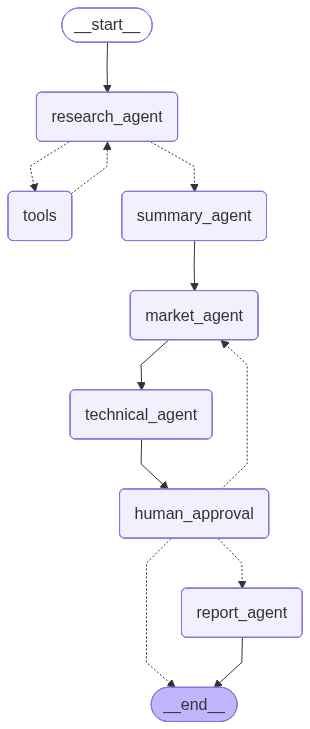

In [12]:
builder = StateGraph(State)

# Add nodes
builder.add_node("research_agent", research_agent)
builder.add_node("tools", research_tool_node)
builder.add_node("summary_agent", summary_agent)
builder.add_node("market_agent", market_agent)
builder.add_node("technical_agent", technical_agent)
builder.add_node("human_approval", human_approval_node)
builder.add_node("report_agent", report_agent)

# Define edges (since we use Command, explicit add_edge is only needed for the fixed parts)
builder.add_edge(START, "research_agent")
builder.add_edge("summary_agent", "market_agent")
builder.add_edge("market_agent", "technical_agent")
builder.add_edge("technical_agent", "human_approval")
builder.add_edge("report_agent", END)

# Compile (a checkpointer is required when using interrupt/resume)
memory = InMemorySaver()
app = builder.compile(checkpointer=memory)

# Visualize the graph
display(Image(app.get_graph().draw_mermaid_png()))

## 6. Main Logic

In [13]:
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

# Theme input
initial_theme = input("Enter a theme:") or "Space debris collection business"
print(f"Theme: {initial_theme}")

# Initial state
initial_state = {
    "research_messages": [HumanMessage(content=f"Theme: {initial_theme}")],
    "loop_count": 0,
    "analysis_messages": [],
}

print("🚀 Running the agent...")

# First run (until completion or until it stops at interrupt)
result = app.invoke(initial_state, config=config)

while True:
    interrupts = result.get("__interrupt__", None)

    # 1) interrupt check (paused)
    if interrupts:
        # Accept list/tuple/single
        first = interrupts[0] if isinstance(interrupts, (list, tuple)) else interrupts
        # If it's an Interrupt object use .value; otherwise use as-is
        interrupt_payload = getattr(first, "value", first)

        print("\n" + "=" * 20 + " 📝 Summary of the discussion so far " + "=" * 20)

        # Prefer analysis_preview if present in the payload
        if isinstance(interrupt_payload, dict) and "analysis_preview" in interrupt_payload:
            previews = interrupt_payload["analysis_preview"]
            if previews:
                for item in previews:
                    print(f"\n--- 🗣️ {item.get('type', 'Message')} ---\n{item.get('content', '')}\n")
            else:
                print("(No analysis data.)")
        else:
            # Compatibility: if not included in payload, display from state
            current_analysis = result.get("analysis_messages", [])
            if current_analysis:
                for msg in current_analysis:
                    content = msg.content if hasattr(msg, "content") else str(msg)
                    content = content if isinstance(content, str) else str(content)
                    print(f"\n--- 🗣️ {type(msg).__name__} ---\n{content[:500]}...\n(omitted)\n")
            else:
                print("(No analysis data.)")

        print("=" * 66 + "\n")

        # 2) approval prompt (use payload question if available)
        if isinstance(interrupt_payload, dict):
            question = interrupt_payload.get("question", "Approve? (y/retry/n)")
            options = interrupt_payload.get("options", ["y", "retry", "n"])
        else:
            question = "Approve? (y/retry/n)"
            options = ["y", "retry", "n"]

        print(f"✋ [Awaiting approval] {question}")
        print(f"🤖 System Message: Please enter {options}")

        user_input = input("User Input (y/retry/n) > ").strip().lower()
        print(f"🔄 Resuming with input: '{user_input}'...")

        # 3) resume (the resume value becomes interrupt()’s return value)
        result = app.invoke(Command(resume=user_input), config=config)
        continue

    # 2) completed (no interrupt)
    print("\n✨ All steps completed.")
    analysis_messages = result.get("analysis_messages", [])
    if analysis_messages:
        last = analysis_messages[-1]
        last_content = last.content if hasattr(last, "content") else str(last)
        print("=" * 60)
        print(last_content)
        print("=" * 60)
    break

Theme: Space debris collection business
🚀 Running the agent...
🔍 Research Agent: thinking...
👉 Tool call: ['tavily_search_formatted', 'tavily_search_formatted', 'tavily_search_formatted', 'tavily_search_formatted', 'tavily_search_formatted', 'tavily_search_formatted']

🐛 [DEBUG] Tool Call #1 (tavily_search_formatted):
{'query': "space debris removal market size 2025 2030 market report market value forecast revenue 'space debris removal market' report 2024 2025 2030"}
----------------------------------------

🐛 [DEBUG] Tool Call #2 (tavily_search_formatted):
{'query': "major companies space debris removal 'key players' Astroscale ClearSpace Northrop Grumman Momentus D-Orbit SpaceX 'space debris' 'debris removal companies'"}
----------------------------------------

🐛 [DEBUG] Tool Call #3 (tavily_search_formatted):
{'query': "technical challenges space debris removal capture technologies nets harpoons robotic arms tethers lasers adjudication 'space debris removal technologies' challenges